# Initialize SparkSession

In [280]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import  when,col, split, substring, coalesce,regexp_replace,avg, to_date, concat, lit
import matplotlib.pyplot as plt
import seaborn as sns
from powerbiclient import Report,QuickVisualize,get_dataset_config, models
from powerbiclient.authentication import DeviceCodeLoginAuthentication,InteractiveLoginAuthentication
import pandas as pd



spark = SparkSession.builder \
    .appName("PySparkEsg") \
    .getOrCreate()


# BRONZE LAYER

### Data extraction from csv files

In [281]:
countries = spark.read.option("header", "true").csv("ESG_Data/ESGCountry.csv").cache()

In [282]:
countries_series = spark.read.option("header", "true").csv("ESG_Data/ESGCountry-series.csv").cache()

In [283]:
esg_data = spark.read.option("header", "true").csv("ESG_Data/ESGCSV.csv").cache()

In [284]:
footnote = spark.read.option("header", "true").csv("ESG_Data/ESGfootnote.csv").cache()

In [285]:
series = spark.read.option("header","true").csv("ESG_Data/ESGSeries.csv").cache()

In [286]:
series_time = spark.read.option("header","true").csv("ESG_Data/ESGSeries-time.csv").cache()

### Ingestion into bronze

##### Bronze Countries 

In [287]:
countries=(countries.select("Country Code","Table Name","Region","Income Group")
            )
bronze_countries=(countries.select([col(c).alias(c.replace(" ", "").replace("-", "")) for c in countries.columns])).cache()

##### Bronze Countries Series

In [288]:
countries_series=(countries_series.select("CountryCode","SeriesCode","DESCRIPTION"))

bronze_countries_series=(countries_series.select([col(c).alias(c.replace(" ", "").replace("-", "")) for c in countries_series.columns])).withColumnRenamed("DESCRIPTION","CountrySerieDescription").cache()

##### Bronze Footnote

In [289]:
bronze_footnote=(footnote.select("CountryCode","SeriesCode","Year").withColumnRenamed("Year","FootNoteYear")).cache()

##### Bronze Esg Data

In [290]:
esg_data=esg_data.drop("Indicator Name")
bronze_esg=(esg_data.select([col(c).alias(c.replace(" ", "").replace("-", "")) for c in esg_data.columns])).cache()

##### Bronze Series

In [291]:
series =(series.select("Series Code","Indicator Name","Topic","Source","Long definition"))
bronze_series=(series.select([col(c).alias(c.replace(" ", "").replace("-", "")) for c in series.columns])).cache()

##### Bronze series time

In [292]:
series_time = series_time.select("SeriesCode","Year","DESCRIPTION")

bronze_series_time= (series_time.select([col(c).alias(c.replace(" ", "").replace("-", "")) for c in series_time.columns]).withColumnRenamed("DESCRIPTION","SeriesTimesDescription").withColumnRenamed("Year","SeriesTimeYear")).cache()


# SILVER LAYER

##### Silver Countries and Country Series

In [293]:
SilverCountry = (bronze_countries
                 .dropDuplicates() 
                 .withColumn("Region", when(col("Region").isNull(), "UnknownRegion")
                                       .otherwise(col("Region")))  
                 .withColumnRenamed("TableName","CountryName")
                 .withColumn("IncomeGroup", when(col("IncomeGroup").isNull(), "Unknown Income Group")
                                       .otherwise(col("IncomeGroup")))  
                 .withColumn("CountryName", regexp_replace(col("CountryName"),"[,\\.]",""))
                )


In [294]:
SilverCountrySeries= (bronze_countries_series
                      .join(bronze_esg,on="CountryCode",how="inner")
                      .select(bronze_countries_series["*"])
                      .dropDuplicates()).cache()

##### Silver Footnote

In [295]:
SilverFootNote=(bronze_footnote.dropDuplicates()
                .withColumn("FootNoteYear", substring(col("FootNoteYear"),3,4))
                ).cache()

##### Silver Time and Time Series

In [296]:
SilverSeries= (bronze_series
             .dropDuplicates()
             .withColumn("MainCategory", split(col("Topic"), ": ")[0])
             .withColumn("SubCategory", split(col("Topic"), ": ")[1])
             
               ).cache()

In [297]:
SilverSeriesTime=(bronze_series_time
                  .dropDuplicates()
                
                  ).cache()

##### Esg Data

In [298]:
SilverEsgData = (
    bronze_esg
    .join(
        bronze_series,
        bronze_esg["IndicatorCode"] == bronze_series["SeriesCode"],
        how="inner"
    )
    .selectExpr(
        "`CountryCode`",
        "`IndicatorCode`",
        f"stack({2023 - 2000 + 1}, " +
        ", ".join([f"'{year}', `{year}`" for year in range(2000, 2024)]) +
        ") as (Year, Value)"
    )
    
    .withColumn("EsgYear", col("Year").cast("string")).drop("Year")
#.withColumn("EsgYear", to_date(concat(col("Year"), lit("-01-01"))))    .drop("Year")
    .withColumn("Value", col("Value").cast("float"))
    .withColumn(
        "Value",
        when(col("Value").isNull(), "Unknown Value").otherwise(col("Value"))
    )
    .withColumn("Value", col("Value").cast("double"))
    # .join(
    #     SilverFootNote,
    #     (bronze_esg["IndicatorCode"] == SilverFootNote["SeriesCode"]) &
    #     (bronze_esg["CountryCode"] == SilverFootNote["CountryCode"]),
    #     how="left"
    # )
    # .withColumn(
    # "FootNoteYear",
    # when(col("FootNoteYear").isNull(), "No Footnote").otherwise(col("FootNoteYear")))
)

#SilverEsgData.show()


# GOLD LAYER

### I this section i'm going to create a dimensional model of this use case in order to organize my data more

In [299]:
FactESG = (SilverEsgData.withColumnRenamed("IndicatorCode","SeriesCode")
           # .join(SilverFootNote, (SilverEsgData["CountryCode"]==SilverFootNote["CountryCode"])&(SilverEsgData["IndicatorCode"]==SilverFootNote["SeriesCode"]))
           ).cache()

#FactESG = FactESG.toPandas()

Country Dimension

In [300]:
DimCountry = (SilverCountry.select("*")).cache()
#DimCountry= DimCountry.toPandas()

Indicator Dimension

In [301]:
DimIndicator = (SilverSeries.select("SeriesCode","IndicatorName","Topic","MainCategory","SubCategory","Source","Longdefinition")).cache()

#DimIndicator= DimIndicator.toPandas()

Countries Series Dimension

In [302]:
DimCountrySeries =(SilverCountrySeries.select("CountryCode","SeriesCode")).cache()

#DimCountrySeries= DimCountrySeries.toPandas()

##### KPIs:


In [320]:
eca="Europe & Central Asia"
mena="Middle East & North Africa"

socialIncome="Income share held by lowest 20%"
environmentEnergy="Renewable energy consumption (% of total final energy consumption)"
environmentColingDays ="Heating Degree Days"
governanceHumainRight="Voice and Accountability: Estimate"


##### Environment

##### Renewable Energy Eu (Belgium, Netherlands, Russia, France and Germany)

In [304]:
from pyspark.sql import functions as F


RenewableEnergyECA= (
    
    FactESG.join(DimIndicator,on="SeriesCode", how="inner").drop(DimIndicator["SeriesCode"])
    .join(DimCountry,on="CountryCode",how="inner").drop(DimCountry["CountryCode"])
    .join(DimCountrySeries, on="CountryCode",how="inner").drop(DimCountrySeries["CountryCode"]).drop(DimCountrySeries["SeriesCode"])
    .where( (col("MainCategory")=="Environment")&(col("IndicatorName")==environmentEnergy))
    .filter((col("Region")== eca))
    .filter(col("CountryName").isin("Belgium", "Netherlands", "Russia", "France", "Germany"))
    .withColumn(
    "IndicatorStatus",
     F.when(F.col("Value") > 50, "Good")
    .when(F.col("Value").isNull(), "N/A")
    .otherwise("Bad"))
    
    
    
).cache()

RenewableEnergyECA = RenewableEnergyECA.toPandas()


ColingDaysClimatECA= (
    
    FactESG.join(DimIndicator,on="SeriesCode", how="inner").drop(DimIndicator["SeriesCode"])
    .join(DimCountry,on="CountryCode",how="inner").drop(DimCountry["CountryCode"])
    .join(DimCountrySeries, on="CountryCode",how="inner").drop(DimCountrySeries["CountryCode"]).drop(DimCountrySeries["SeriesCode"])
    .where( (col("MainCategory")=="Environment")&(col("IndicatorName")==environmentColingDays))
    .filter((col("Region")== eca))
    .filter(col("CountryName").isin("Belgium", "Netherlands", "Russia", "France", "Germany"))

    
).cache()

ColingDaysClimatECA = ColingDaysClimatECA.toPandas()


In [305]:
#Energy metrics
""" Average Renewable Energy Consumption by Country """
avg_renewable_by_country = RenewableEnergyECA.groupby("CountryName")["Value"].mean()

""" Trend of Renewable Energy Consumption Over Time """
renewable_trend = RenewableEnergyECA.groupby(["CountryName", "EsgYear"])["Value"].mean().reset_index()

""" Ranking of Countries by Renewable Energy Adoption """
latest_year = RenewableEnergyECA["EsgYear"].max()
renewable_ranking = RenewableEnergyECA[RenewableEnergyECA["EsgYear"] == latest_year].sort_values(by="Value", ascending=False)

""" Regional Renewable Energy Adoption """
regional_total = RenewableEnergyECA.groupby("EsgYear")["Value"].sum().reset_index()


In [306]:
# COling Days CLimat 

""" Average Cooling Degree Days by Country """
avg_cooling_days_by_country = ColingDaysClimatECA.groupby("CountryName")["Value"].mean()

""" Trend of Cooling Degree Days Over Time """
cooling_trend = ColingDaysClimatECA.groupby(["CountryName", "EsgYear"])["Value"].mean().reset_index()

""" Correlation Between Cooling Degree Days and Renewable Energy Consumption """
combined_data = pd.merge(RenewableEnergyECA, ColingDaysClimatECA, on=["CountryName", "EsgYear"], suffixes=("_renewable", "_cooling"))
correlation = combined_data[["Value_renewable", "Value_cooling"]].corr()

""" Extreme Cooling Degree Days Analysis """
extreme_cooling_days = ColingDaysClimatECA.groupby("CountryName")["Value"].max().reset_index()



In [307]:
""" Energy Efficiency in Hotter Climates """
combined_data["Efficiency"] = combined_data["Value_renewable"] / combined_data["Value_cooling"]

""" Impact of Temperature on Renewable Energy """
impact_analysis = combined_data.groupby("EsgYear")[["Value_renewable", "Value_cooling"]].mean()


##### Renewable Energy Mena (Morocco, United Arab Emirates, UAE)

In [308]:
RenewableEnergyMENA= (
    
    FactESG.join(DimIndicator,on="SeriesCode", how="inner").drop(DimIndicator["SeriesCode"])
    .join(DimCountry,on="CountryCode",how="inner").drop(DimCountry["CountryCode"])
    .join(DimCountrySeries, on="CountryCode",how="inner").drop(DimCountrySeries["CountryCode"]).drop(DimCountrySeries["SeriesCode"])
    .where((col("Region")==mena) & (col("CountryName").isin("Morocco","Qatar","United Arab Emirates")) & (col("IndicatorName")==environmentEnergy))
    .dropDuplicates()
    
).cache()

RenewableEnergyMENA = RenewableEnergyMENA.toPandas()

ColingDaysClimatMena= (
    
    FactESG.join(DimIndicator,on="SeriesCode", how="inner").drop(DimIndicator["SeriesCode"])
    .join(DimCountry,on="CountryCode",how="inner").drop(DimCountry["CountryCode"])
    .join(DimCountrySeries, on="CountryCode",how="inner").drop(DimCountrySeries["CountryCode"]).drop(DimCountrySeries["SeriesCode"])
    .where((col("Region")==mena) & (col("IndicatorName")==environmentColingDays))
 
   .dropDuplicates()
).cache()


ColingDaysClimatMena = ColingDaysClimatMena.toPandas()

##### Social

In [309]:
SocialIncomeEca= (
    
    FactESG.join(DimIndicator,on="SeriesCode", how="inner").drop(DimIndicator["SeriesCode"])
    .join(DimCountry,on="CountryCode",how="inner").drop(DimCountry["CountryCode"])
    .join(DimCountrySeries, on="CountryCode",how="inner").drop(DimCountrySeries["CountryCode"]).drop(DimCountrySeries["SeriesCode"])
    .where((col("Region")==mena) & (col("CountryName").isin("Morocco","Qatar","United Arab Emirates")) & (col("IndicatorName")==socialIncome))

   .dropDuplicates()
    
).cache()

SocialIncomeEca = SocialIncomeEca.toPandas()

SocialIncomeMena= (
    
    FactESG.join(DimIndicator,on="SeriesCode", how="inner").drop(DimIndicator["SeriesCode"])
    .join(DimCountry,on="CountryCode",how="inner").drop(DimCountry["CountryCode"])
    .join(DimCountrySeries, on="CountryCode",how="inner").drop(DimCountrySeries["CountryCode"]).drop(DimCountrySeries["SeriesCode"])
    .where((col("Region")==mena)  & (col("IndicatorName")==socialIncome))
 
   .dropDuplicates()

).cache()


SocialIncomeMena = SocialIncomeMena.toPandas()

##### Governance

In [323]:
VoiceAndAccountability= (
    
    FactESG.join(DimIndicator,on="SeriesCode", how="inner").drop(DimIndicator["SeriesCode"])
    .join(DimCountry,on="CountryCode",how="inner").drop(DimCountry["CountryCode"])
    .join(DimCountrySeries, on="CountryCode",how="inner").drop(DimCountrySeries["CountryCode"]).drop(DimCountrySeries["SeriesCode"])
    .where( (col("CountryName").isin("Morocco","Netherlands","India","Qatar","United Arab Emirates")) & (col("IndicatorName")==governanceHumainRight))
    .dropDuplicates()
    
).cache()

VoiceAndAccountability = VoiceAndAccountability.toPandas()

# Reporting

##### Average Renewable Energy Consumption by Country 

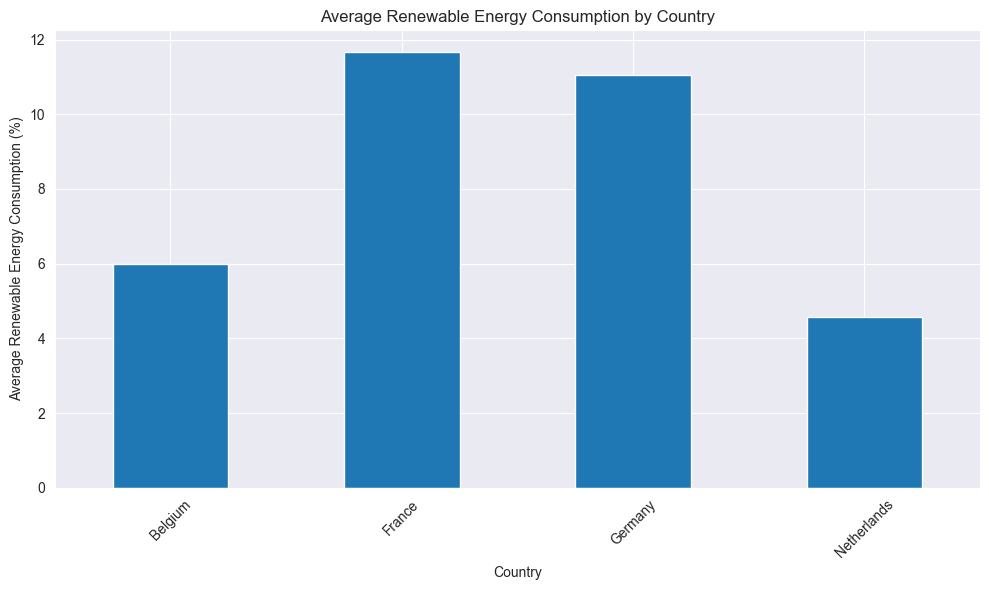

In [310]:
avg_renewable_by_country.plot(kind='bar', figsize=(10, 6), title='Average Renewable Energy Consumption by Country')
plt.xlabel('Country')
plt.ylabel('Average Renewable Energy Consumption (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Trend of Renewable Energy Consumption In the last two decades

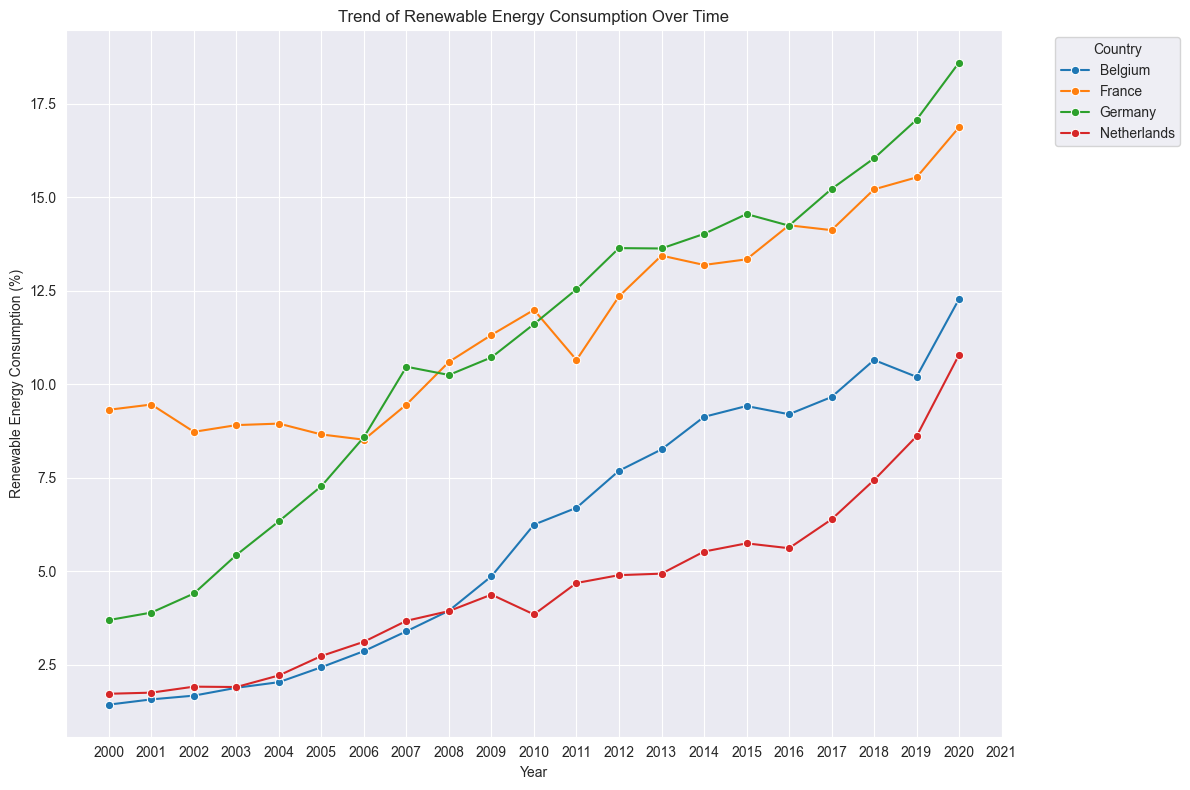

In [311]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=renewable_trend, x="EsgYear", y="Value", hue="CountryName", marker="o")
plt.title("Trend of Renewable Energy Consumption Over Time")
plt.xlabel("Year")
plt.ylabel("Renewable Energy Consumption (%)")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

##### Regional Renewable Energy Adoption

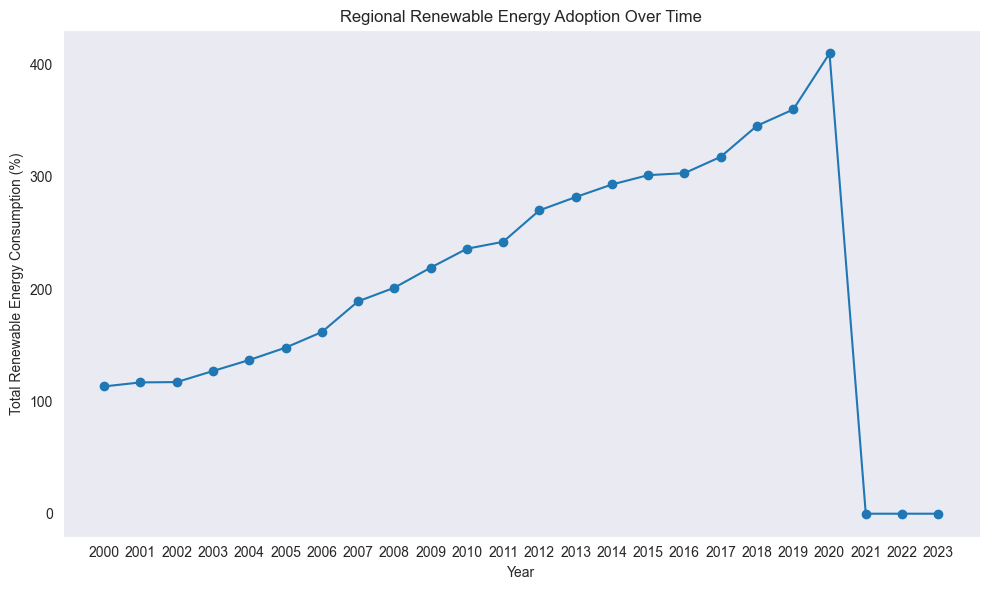

In [312]:
plt.figure(figsize=(10, 6))
plt.plot(regional_total["EsgYear"], regional_total["Value"], marker="o")
plt.title("Regional Renewable Energy Adoption Over Time")
plt.xlabel("Year")
plt.ylabel("Total Renewable Energy Consumption (%)")
plt.grid()
plt.tight_layout()
plt.show()


In [313]:
auth= InteractiveLoginAuthentication()

A local browser window will open for interactive sign in.

Interactive authentication successfully completed.
You are now logged in.

The result should be passed only to trusted code in your notebook.


In [314]:
PBI_visualizeEca=QuickVisualize(get_dataset_config(RenewableEnergyECA), auth=auth)

In [315]:
PBI_visualizeMena=QuickVisualize(get_dataset_config(RenewableEnergyMENA), auth=auth)

In [316]:
PBI_visualizeEca

QuickVisualize()

In [317]:
PBI_visualizeMena

QuickVisualize()